#  Multi-Output MLP for Side-Channel Analysis 
- ASCAD Dataset
    - No 1st order data leakage
    - Aligned (suitable for MLP) 
- Nonprofiled attack

- 256 different key guesses "k" 
    - each with it's own, individually tracked hidden network and loss
- LSB leakage model: $ L_k = \text{Sbox}[P \oplus k] \mod 2 $


# 1. Imports

In [ ]:
import os
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import from src package
from src.config import (
    LEARNING_RATE, SHARED_DIM, BRANCH_LAYER_1, BRANCH_LAYER_2, OUTPUT_CLASSES,
    NUM_TRACES, TRACE_START_IDX, TARGET_BYTE_IDX, BATCH_SIZE, NUM_EPOCHS,
    FILE_PATH, AES_Sbox, CHECKPOINT_DIR, MODEL_FILENAME
)
from src.model import MultiOutputNet, save_model
from src.utils import load_ascad, normalize_traces, generate_labels

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Hyperparameters
Ranked by estimated impact on model performance

In [ ]:
# Hyperparameters are imported from src/config.py
# You can override them here if needed for experimentation:

# LEARNING_RATE = 0.0005       # [1e-5, 1e-2]
# SHARED_DIM = 0               # 0 = no shared layer, try [50, 100, 200]
# BRANCH_LAYER_1 = 20          # Suggested range: [10, 50]
# BRANCH_LAYER_2 = 10          # Suggested range: [5, 25]
# OUTPUT_CLASSES = 2           # Binary classification (LSB leakage model)
# NUM_TRACES = 10000           # For ASCAD: 10k -> 50k
# TRACE_START_IDX = 0          # Starting index in dataset
# BATCH_SIZE = 100             # [32, 256]
# NUM_EPOCHS = 30              # Researchers see success in ~6 epochs
# TARGET_BYTE_IDX = 2          # ASCAD shows 2nd-order leakage at byte index 2

print("Current configuration (from src/config.py):")
print(f"  LEARNING_RATE:  {LEARNING_RATE}")
print(f"  SHARED_DIM:     {SHARED_DIM}")
print(f"  BRANCH_LAYER_1: {BRANCH_LAYER_1}")
print(f"  BRANCH_LAYER_2: {BRANCH_LAYER_2}")
print(f"  NUM_EPOCHS:     {NUM_EPOCHS}")
print(f"  NUM_TRACES:     {NUM_TRACES}")
print(f"  BATCH_SIZE:     {BATCH_SIZE}")

Current configuration (from src/config.py):
  LEARNING_RATE:  0.0005
  SHARED_DIM:     0
  BRANCH_LAYER_1: 20
  BRANCH_LAYER_2: 10
  NUM_EPOCHS:     30
  NUM_TRACES:     10000
  BATCH_SIZE:     100


## 2. Dataset Loading 

In [ ]:
# Load data using imported functions (FILE_PATH, AES_Sbox from src/config.py)
traces, plaintexts, real_key = load_ascad(
    FILE_PATH, 
    num_traces=NUM_TRACES, 
    start_idx=TRACE_START_IDX, 
    target_byte=TARGET_BYTE_IDX
)

# Normalize traces and convert to tensor
traces_tensor = normalize_traces(traces)
print("Traces shape:", traces_tensor.shape)
print("Real Key Byte:", hex(real_key))

Traces shape: torch.Size([10000, 700])
Real Key Byte: 0xe0


## 3. Label Generation

We generate 256 sets of labels, one for each key candidate.

In [ ]:
# Generate labels using imported function (uses LSB leakage model)
labels_tensor = generate_labels(plaintexts)
print("Labels shape:", labels_tensor.shape)

Labels shape: torch.Size([10000, 256])


## 4. Multi-Output Model Architecture

- Shared Layer (optional): Research shows 200 is most efficient for compute
- 256 Branches: Dense(20) -> ReLU -> Dense(10) -> ReLU -> Dense(2)

In [ ]:
# Create model using imported class from src/model.py
input_dim = traces_tensor.shape[1]  # Dynamically get input dimension

model = MultiOutputNet(
    input_dim=input_dim,
    shared_dim=SHARED_DIM,
    branch_l1=BRANCH_LAYER_1,
    branch_l2=BRANCH_LAYER_2,
    output_classes=OUTPUT_CLASSES
).to(device)

print(f"Model created with input_dim={input_dim}, shared_dim={SHARED_DIM}, branches={BRANCH_LAYER_1}→{BRANCH_LAYER_2}→{OUTPUT_CLASSES}")

Model created with input_dim=700, shared_dim=0, branches=20→10→2


## 5. Training Loop

- Loss Per-branch: $\mathcal{L}^{[k]} = -\frac{1}{N_s}\sum y_{true} \ln(z)$ (cross-entropy)
- Total Loss: - Total: $\mathcal{L}_{total} = \frac{1}{256}\sum_{k=1}^{256} \mathcal{L}^{[k]}$ (mean for gradient stability)
- Optimizer: Adam

In [6]:
dataset = TensorDataset(traces_tensor, labels_tensor)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

history_loss = []

# To track scores of each key guess (higher score = more likely correct key)
# Score = negative loss, so correct key (lowest loss) has highest score
key_scores = np.zeros((NUM_EPOCHS, 256))

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    
    pbar = tqdm(loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}')
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data) # (Batch, 256, 2)
        
        # Compute loss: Average of CrossEntropy per branch
        # For each branch k, compute CrossEntropyLoss, then average over all 256 branches
        loss = 0
        for k in range(256):
            loss += criterion(output[:, k, :], target[:, k])
        loss = loss / 256
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    print(f"Epoch {epoch+1} Avg Loss: {total_loss / len(loader)}")
    
    # Validation: Check loss per branch on the whole set (or subset)
    model.eval()
    with torch.no_grad():
        # Compute full validation loss per branch
        # To avoid OOM, do in batches
        val_accum_loss = torch.zeros(256, device=device)
        val_count = 0
        
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            out = model(data) # (B, 256, 2)
            
            # Compute loss per branch alone
            for k in range(256):
                val_accum_loss[k] += nn.CrossEntropyLoss(reduction='sum')(out[:, k, :], target[:, k])
            
            val_count += data.size(0)
            
        avg_branch_losses = val_accum_loss / val_count
        # Convert loss to score: negate so that lower loss = higher score
        key_scores[epoch] = -avg_branch_losses.cpu().numpy()
        
        # Rank keys by score (descending - highest score is best)
        sorted_keys = np.argsort(key_scores[epoch])[::-1]  # Reverse for descending order
        best_score_key = sorted_keys[0]
        rank_of_real = np.where(sorted_keys == real_key)[0][0]
        
        print(f"Best Key: {hex(best_score_key)}, Real Key Rank: {rank_of_real}, Real Key Score: {key_scores[epoch][real_key]:.4f}")

Epoch 1/30: 100%|█████████████████████████████████████████| 100/100 [00:19<00:00,  5.18it/s]


Epoch 1 Avg Loss: 0.696611783504486
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6864


Epoch 2/30: 100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  6.13it/s]


Epoch 2 Avg Loss: 0.6936211675405503
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6733


Epoch 3/30: 100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  6.10it/s]


Epoch 3 Avg Loss: 0.6922239673137665
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6723


Epoch 4/30: 100%|█████████████████████████████████████████| 100/100 [00:17<00:00,  5.78it/s]


Epoch 4 Avg Loss: 0.691042629480362
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6580


Epoch 5/30: 100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  6.20it/s]


Epoch 5 Avg Loss: 0.6898380994796753
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6540


Epoch 6/30: 100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  5.90it/s]


Epoch 6 Avg Loss: 0.6886307495832443
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6471


Epoch 7/30: 100%|█████████████████████████████████████████| 100/100 [00:17<00:00,  5.65it/s]


Epoch 7 Avg Loss: 0.687338804602623
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6498


Epoch 8/30: 100%|█████████████████████████████████████████| 100/100 [00:17<00:00,  5.66it/s]


Epoch 8 Avg Loss: 0.6858876723051072
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6418


Epoch 9/30: 100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  6.01it/s]


Epoch 9 Avg Loss: 0.6843670356273651
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6401


Epoch 10/30: 100%|████████████████████████████████████████| 100/100 [00:17<00:00,  5.72it/s]


Epoch 10 Avg Loss: 0.6825622266530991
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6439


Epoch 11/30: 100%|████████████████████████████████████████| 100/100 [00:18<00:00,  5.54it/s]


Epoch 11 Avg Loss: 0.680775995850563
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6326


Epoch 12/30: 100%|████████████████████████████████████████| 100/100 [00:16<00:00,  6.14it/s]


Epoch 12 Avg Loss: 0.6787934225797653
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6312


Epoch 13/30: 100%|████████████████████████████████████████| 100/100 [00:16<00:00,  6.09it/s]


Epoch 13 Avg Loss: 0.6765863633155823
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6263


Epoch 14/30: 100%|████████████████████████████████████████| 100/100 [00:17<00:00,  5.80it/s]


Epoch 14 Avg Loss: 0.6742115563154221
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6241


Epoch 15/30: 100%|████████████████████████████████████████| 100/100 [00:16<00:00,  5.99it/s]


Epoch 15 Avg Loss: 0.6718223184347153
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6198


Epoch 16/30: 100%|████████████████████████████████████████| 100/100 [00:16<00:00,  5.93it/s]


Epoch 16 Avg Loss: 0.6690949839353562
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6191


Epoch 17/30: 100%|████████████████████████████████████████| 100/100 [00:17<00:00,  5.68it/s]


Epoch 17 Avg Loss: 0.6664386188983917
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6112


Epoch 18/30: 100%|████████████████████████████████████████| 100/100 [00:17<00:00,  5.61it/s]


Epoch 18 Avg Loss: 0.6635477674007416
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6086


Epoch 19/30: 100%|█████████████████████████| 100/100 [00:16<00:00,  6.05it/s]


Epoch 19 Avg Loss: 0.6605322861671448
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6101


Epoch 20/30: 100%|█████████████████████████| 100/100 [00:17<00:00,  5.82it/s]


Epoch 20 Avg Loss: 0.657564749121666
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6078


Epoch 21/30: 100%|█████████████████████████| 100/100 [00:17<00:00,  5.86it/s]


Epoch 21 Avg Loss: 0.6543922346830368
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.5967


Epoch 22/30: 100%|█████████████████████████| 100/100 [00:16<00:00,  6.16it/s]


Epoch 22 Avg Loss: 0.650989710688591
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.5912


Epoch 23/30: 100%|█████████████████████████| 100/100 [00:17<00:00,  5.86it/s]


Epoch 23 Avg Loss: 0.6476488637924195
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.5907


Epoch 24/30: 100%|█████████████████████████| 100/100 [00:17<00:00,  5.72it/s]


Epoch 24 Avg Loss: 0.6441589713096618
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.5816


Epoch 25/30: 100%|█████████████████████████| 100/100 [00:16<00:00,  6.16it/s]


Epoch 25 Avg Loss: 0.6405682897567749
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.5809


Epoch 26/30: 100%|█████████████████████████| 100/100 [00:16<00:00,  6.14it/s]


Epoch 26 Avg Loss: 0.637067129611969
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.5740


Epoch 27/30: 100%|█████████████████████████| 100/100 [00:17<00:00,  5.87it/s]


Epoch 27 Avg Loss: 0.633400012254715
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.5711


Epoch 28/30: 100%|█████████████████████████| 100/100 [00:16<00:00,  6.02it/s]


Epoch 28 Avg Loss: 0.6298509168624878
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.5688


Epoch 29/30: 100%|█████████████████████████| 100/100 [00:16<00:00,  5.95it/s]


Epoch 29 Avg Loss: 0.6261658418178558
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.5617


Epoch 30/30: 100%|█████████████████████████| 100/100 [00:17<00:00,  5.78it/s]


Epoch 30 Avg Loss: 0.6222079610824585
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.5614


## 6. Results Analysis

Visualize the attack results with multiple charts.

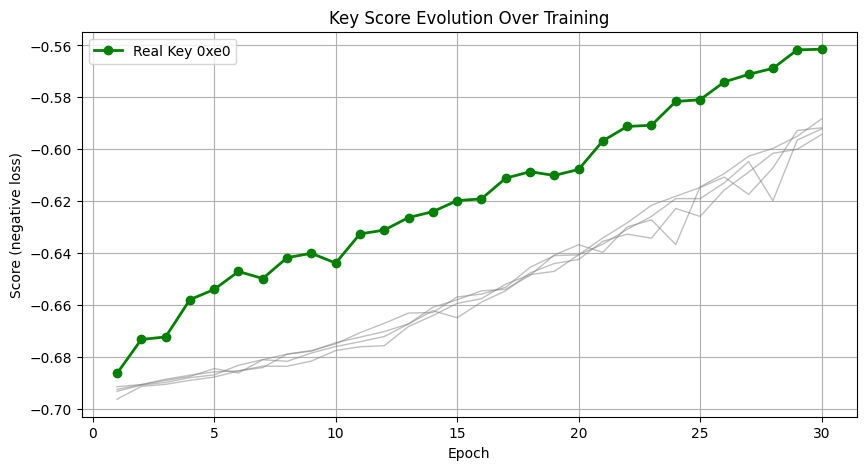

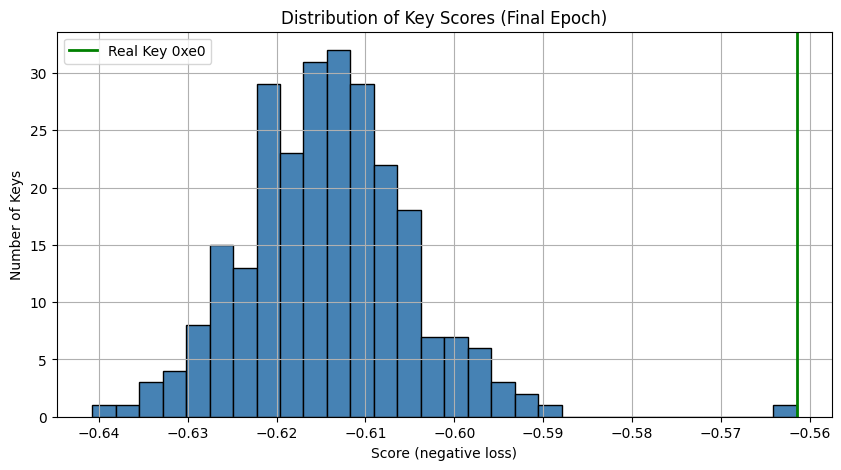

In [7]:
# Get the final scores for all 256 key guesses
final_scores = key_scores[-1]
epochs_range = np.arange(1, NUM_EPOCHS + 1)

# Calculate the rank of the real key at each epoch
real_key_ranks = []
for epoch in range(NUM_EPOCHS):
    sorted_keys = np.argsort(key_scores[epoch])[::-1]  # Sort by score (highest first)
    rank = np.where(sorted_keys == real_key)[0][0] + 1  # +1 for 1-based ranking
    real_key_ranks.append(rank)

# ---- Chart 1: Key Score Evolution ----
plt.figure(figsize=(10, 5))

# Plot a few wrong keys in gray
sorted_final = np.argsort(final_scores)[::-1]
for k in sorted_final[:5]:
    if k != real_key:
        plt.plot(epochs_range, key_scores[:, k], color='gray', alpha=0.5, linewidth=1)

# Plot the real key in green
plt.plot(epochs_range, key_scores[:, real_key], color='green', linewidth=2, 
         marker='o', label=f'Real Key {hex(real_key)}')

plt.xlabel('Epoch')
plt.ylabel('Score (negative loss)')
plt.title('Key Score Evolution Over Training')
plt.legend()
plt.grid(True)
plt.show()

# ---- Chart 2: Score Distribution at Final Epoch ----
plt.figure(figsize=(10, 5))

plt.hist(final_scores, bins=30, color='steelblue', edgecolor='black')
plt.axvline(x=final_scores[real_key], color='green', linewidth=2, label=f'Real Key {hex(real_key)}')

plt.xlabel('Score (negative loss)')
plt.ylabel('Number of Keys')
plt.title('Distribution of Key Scores (Final Epoch)')
plt.legend()
plt.grid(True)
plt.show()



In [8]:
# Print summary
print("=" * 50)
print("ATTACK SUMMARY")
print("=" * 50)
print(f"Target Key Byte:  {hex(real_key)}")
print(f"Final Rank:       {real_key_ranks[-1]}")
print(f"Final Score:      {final_scores[real_key]:.4f}")

if real_key_ranks[-1] == 1:
    print("Result:           KEY RECOVERED!")
else:
    print(f"Result:           Key not recovered (rank {real_key_ranks[-1]})")
print("=" * 50)

ATTACK SUMMARY
Target Key Byte:  0xe0
Final Rank:       1
Final Score:      -0.5614
Result:           KEY RECOVERED!


## 7. Save Model

Save the trained model to the checkpoints directory for later use in demos.


In [9]:
# Save the trained model
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
model_path = os.path.join(CHECKPOINT_DIR, MODEL_FILENAME)

# Prepare config dict for saving
config_dict = {
    'LEARNING_RATE': LEARNING_RATE,
    'SHARED_DIM': SHARED_DIM,
    'BRANCH_LAYER_1': BRANCH_LAYER_1,
    'BRANCH_LAYER_2': BRANCH_LAYER_2,
    'OUTPUT_CLASSES': OUTPUT_CLASSES,
    'NUM_TRACES': NUM_TRACES,
    'NUM_EPOCHS': NUM_EPOCHS,
    'BATCH_SIZE': BATCH_SIZE,
    'TARGET_BYTE_IDX': TARGET_BYTE_IDX,
    'input_dim': input_dim,
}

# Prepare metadata with training results
metadata = {
    'real_key': int(real_key),
    'final_rank': real_key_ranks[-1],
    'final_score': float(final_scores[real_key]),
    'key_recovered': real_key_ranks[-1] == 1,
}

# Save model using the helper function
save_model(model, model_path, config=config_dict, metadata=metadata)

print(f"\nModel checkpoint saved with:")
print(f"  - Config: {len(config_dict)} parameters")
print(f"  - Metadata: Final rank={metadata['final_rank']}, Key recovered={metadata['key_recovered']}")


Model saved to checkpoints/multi_output_sca.pt

Model checkpoint saved with:
  - Config: 10 parameters
  - Metadata: Final rank=1, Key recovered=True
